In [1]:
# imports
import math, random

# import gym
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
# USE_CUDA = torch.cuda.is_available()
# Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class MonkRNN(nn.Module):
    def __init__(self, inp_size, n_neurons, out_size, rnn_nonlinearity = 'relu',curl_field=False):
        super(MonkRNN, self).__init__()
        
        
        
        # simplify
        
        # input -> ReLU RNN -> Linear -> ReLU -> Linear -> Curl field and friction  -> output (velocity x, velocity y)
        
        # Loss - squared error with target velocity + l2 regularization on all parameters

        self.inp_size = inp_size
        self.out_size = out_size
        self.n_neurons = n_neurons
        self.init_hidden_state = nn.Parameter(torch.zeros(1, n_neurons))

        # Inputs are:
        
        # Recurrent layer parameters.
        self.rnn = nn.RNNCell(input_size=n_neurons,hidden_size=n_neurons,nonlinearity=rnn_nonlinearity)
        self.rnn.weight_hh.data.normal_(0, 2 / np.sqrt(n_neurons))

        # Output layer parameters
        self.out_layer = nn.Sequential(nn.Linear(n_neurons, n_neurons), nn.ReLU(), nn.Linear(n_neurons, out_size))
        self.out_layer[0].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
        self.out_layer[2].weight.data.normal_(0, 1.5 / np.sqrt(n_neurons))
        
        

    def forward(self, inp, curl, h_old=None):
        """
        Parameters
        ----------
        inp : torch.tensor
            Hand and target positions. Has shape (7,).
            (go, hand_x, hand_y, curr_tgx, curr_tgy, next_tgx, next_tgy)
        hidden : torch.tensor
            Initial firing rates. Has shape (n_neurons,)
        task_info : torch.tensor
            tensor holding (go, curr_tgx, curr_tgy, next_tgx, next_tgy)

        Returns
        -------
        acc : torch.tensor
            has shape (2,) corresponding to x and y acceleration.
        hiddens : torch.tensor
            has shape (n_neurons,) corresponding network activity.
        """

        if h_old is None:
            h_old = self.init_hidden_state

        # Update RNN one time step.
        h_new = self.rnn(inp, h_old)

        # Collect RNN output (acceleration of hand).
        dv = self.out_layer(h_new)
        
        dv = dv + curl
        
        
        # print("hidden {}, Acc {}".format(h_new, acc))
        return dv, h_new
    
   

In [111]:
class GenerateInputTargetTimeseries():
    def __init__(self,curl=False):
        self.max_pos = 50
        self.min_pos = -50
        self.max_target_acc = 1
        self.go_cue = 'pulsed'
        self.Tx = 100
        self.T_on = 20
        self.T_off = 80
        self.max_go_delay = 10
        self.width_go_cue=5
        self.tau=3 # time constant for generating sigmoidal movements
        self.curl=curl
        self.curl_xlims = [-20,20]
        self.curl_xmag=-5
        self.curl_ymag = 0
        self.curl_ylims = [-5,50]

    def get_minibatch(self, m):
        """
        Parameters
        ----------
        m : int, minibatch size
        Returns
        -------
        X : torch.tensor
            has shape (m,3,Tx), 3 timeseries for target position and go signal
        Y : torch.tensor
            has shape (m,2,Tx), target acceleration timeseries 
        CURL : torch.tensor
            has shape (m,2,Tx), curl force applied 
        """
        
        
        # generate m target positions
        targ_pos = (self.max_pos-self.min_pos)*np.random.rand(m,2)+self.min_pos
        go_time = self.T_on + np.random.randint(self.max_go_delay,size=[m,1])
        
        
        # create input timeseries
        X = np.zeros((m,3,self.Tx))
        X[:,:2,self.T_on:self.T_off] = targ_pos[:,:,np.newaxis]
        for i in range(self.width_go_cue): # Start cue
            X[:,2,go_time.ravel()+i] = 10
        
        # create output timeseries
        t = np.linspace(0,self.Tx,num=self.Tx)[np.newaxis,np.newaxis,:]
#         print(targ_pos.shape,)
        pos = targ_pos[:,:,np.newaxis]/(1+np.exp(-(t-5*self.tau - go_time[:,:,np.newaxis])/self.tau))
        Y = np.diff(np.diff(pos,prepend=0),prepend=0)
        
        
        # curl forces
        CURL = np.zeros((m,2,self.Tx))
        if self.curl:
            # apply x curl
            curlx = CURL[:,0,:]
            curlx[(pos[:,0,:]>=self.curl_xlims[0]) & (pos[:,0,:]<=self.curl_xlims[1])] = self.curl_xmag
            # apply y curl
            curly= CURL[:,1,:]
            curly[(pos[:,1,:]>=self.curl_ylims[0]) & (pos[:,1,:]<=self.curl_ylims[1])] = self.curl_xmag
        
        # create curl 
        return torch.from_numpy(X).to(device), torch.from_numpy(Y).to(device), torch.from_numpy(CURL).to(device)

In [112]:
dataclass = GenerateInputTargetTimeseries(curl=True)
X,Y,CURL= dataclass.get_minibatch(10)

In [113]:
print(X.shape,Y.shape,CURL.shape)

torch.Size([10, 3, 100]) torch.Size([10, 2, 100]) torch.Size([10, 2, 100])


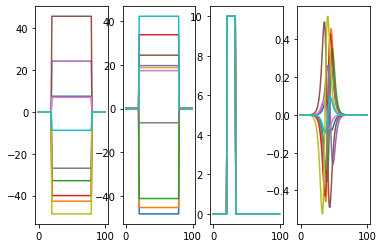

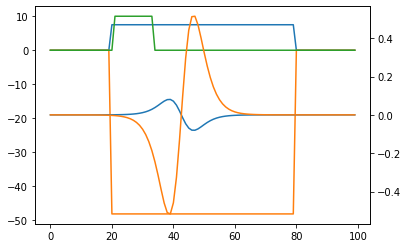

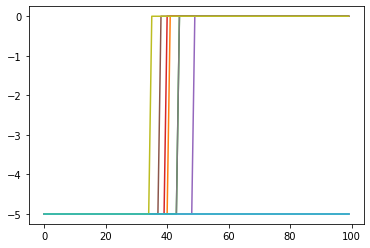

In [114]:
f,ax = plt.subplots(1,4)
ax[0].plot(X[:,0,:].T)
ax[1].plot(X[:,1,:].T)
ax[2].plot(X[:,2,:].T)
ax[3].plot(Y[:,0,:].T)

f,ax = plt.subplots()
ax.plot(X[0,:,:].T)
ax2 = ax.twinx()
ax2.plot(Y[0,:,:].T)

f,ax = plt.subplots()
ax.plot(CURL[:,0,:].T)

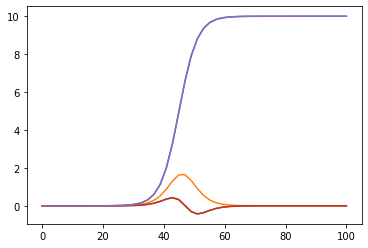

In [68]:
t = np.linspace(0,100)
f,ax = plt.subplots()
tau = 3.
A = 10
pos = A/(1+np.exp(-(t-5*tau-30)/tau))
vel = np.diff(pos,prepend = 0)
acc = np.diff(vel,prepend = 0)
ax.plot(t,pos)
ax.plot(t,vel)
ax.plot(t,acc)
ax.plot(t,np.diff(pos,n=2,prepend=[0,0]))
ax.plot(t,np.cumsum(np.cumsum(acc)))